<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/TRAIN_Store_Dept_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [ ]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y.pkl'
sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Mounted at /content/drive
(45974682, 119)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,enc_std_store_id_dept_id,enc_mean_item_id,enc_std_item_id,enc_mean_item_id_state_id,enc_std_item_id_state_id,enc_mean_item_id_store_id,enc_std_item_id_store_id,ROP_L3,ROP_L7,ROP_L14
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,5.0,NaN,NaN
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,7.0,NaN,NaN
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,6.0,NaN,NaN


In [ ]:
# Group
group_key = ['store_id', 'dept_id']

group_names = sales_long_val[group_key].drop_duplicates().values.tolist()
print(f"Total groups: {len(group_names)}")

Total groups: 70


In [ ]:
sales_long_val['d'].min(), sales_long_val['d'].max()

(np.int16(1), np.int16(1913))

# ML Forecasting

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from tqdm import tqdm

# LightGBM Parameter settings
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.7,
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'num_leaves': 2**7 - 1,
    'min_data_in_leaf': 2**6 - 1,
    'feature_fraction': 0.7,
    'max_bin': 100,
    'n_estimators': 2500,
    'boost_from_average': False,
    'verbose': -1,
    'seed': 1995
}


In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in ['weekday']:
    if sales_long_val[col].dtype == 'object':
        le = LabelEncoder()
        sales_long_val[col] = le.fit_transform(sales_long_val[col])


In [ ]:
!pip install tqdm

# Result & Model Save

In [ ]:
label_col = 'ROP_L3'
group_key = ['store_id', 'dept_id']
remove_feature=[
        # ID
        'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
        'd', 'date', 'wm_yr_wk','sales',

        # ROP label
        'ROP_L3', 'ROP_L7', 'ROP_L14',

        # mean encoding, avoid target leakage
        'enc_mean_store_id', 'enc_std_store_id',
        'enc_mean_dept_id', 'enc_std_dept_id',
        'enc_mean_store_id_cat_id', 'enc_std_store_id_cat_id',
        'enc_mean_state_id_dept_id', 'enc_std_state_id_dept_id',
        'enc_mean_store_id_dept_id', 'enc_std_store_id_dept_id',
        'enc_mean_item_id_store_id', 'enc_std_item_id_store_id']

In [ ]:
import os, gc, pickle, time
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm

# Drop training period constant to avoid LGB instability
def _fit_lgb_safe(X_tr, y_tr, params):
    n = X_tr.shape[0]
    const_cols = [c for c in X_tr.columns if X_tr[c].nunique(dropna=True) <= 1]
    if const_cols:
        X_tr = X_tr.drop(columns=const_cols)

    safe = dict(params or {})
    safe['min_data_in_leaf'] = max(5, min(safe.get('min_data_in_leaf', 20), max(2, n // 4)))
    safe['num_leaves']       = min(safe.get('num_leaves', 31), max(2, n - 1))
    safe['force_row_wise']   = True

    mdl = lgb.LGBMRegressor(**safe)
    mdl.fit(X_tr, y_tr)
    return mdl, const_cols

# Calculate the d boundary of "3 years of training + validation = the last 3 months of Y4" (automatically do a robust mapping of date → d)
def make_ranges_train3y_val_last3m(df, date_col='date', d_col='d', lead_time=3):
    dd = df[[date_col, d_col]].drop_duplicates().sort_values(date_col)
    if not np.issubdtype(dd[date_col].dtype, np.datetime64):
        dd[date_col] = pd.to_datetime(dd[date_col])

    start    = dd[date_col].min().normalize()
    y4_end   = start + pd.DateOffset(years=4) - pd.Timedelta(days=1)
    # The day following the last three months of the year ending in Y4 (val start)
    val_start_date = (y4_end - pd.DateOffset(months=3)) + pd.Timedelta(days=1)
    # 3 years before the verification starting point (train start)
    train_start_date = val_start_date - pd.DateOffset(years=3)

    # Date → d (take the minimum d >= starting point and the maximum d <= end point)
    d_val_start = int(dd.loc[dd[date_col] >= val_start_date, d_col].min())
    d_y4_end    = int(dd.loc[dd[date_col] <= y4_end,         d_col].max())
    d_train_start = int(dd.loc[dd[date_col] >= train_start_date, d_col].min())
    '''
    The training upper bound should be reduced by L; the validation upper bound
    should be reduced by (L-1) to avoid cross-window/Year5
    '''
    L = int(lead_time)
    d_train_end = d_val_start - L
    d_val_end   = d_y4_end  - (L - 1)

    if d_train_end < d_train_start:
        raise ValueError("The 3-year training window is insufficient.")

    # Record meta
    date_at = dd.drop_duplicates(d_col).set_index(d_col)[date_col]
    train_start_date = pd.to_datetime(date_at.loc[d_train_start]).date()
    train_end_date   = pd.to_datetime(date_at.loc[d_train_end]).date()
    val_start_date   = pd.to_datetime(date_at.loc[d_val_start]).date()
    val_end_date     = pd.to_datetime(date_at.loc[d_val_end]).date()

    info = {
        "y4_end_date": y4_end.date(),
        "train_start_d": int(d_train_start),
        "train_end_d":   int(d_train_end),
        "val_start_d":   int(d_val_start),
        "val_end_d":     int(d_val_end),
        "train_start_date": train_start_date,
        "train_end_date":   train_end_date,
        "val_start_date":   val_start_date,
        "val_end_date":     val_end_date,
        "lead_time":        L
    }
    return (int(d_train_start), int(d_train_end)), (int(d_val_start), int(d_val_end)), info

# Main Function
def run_train_val_train3y_val_last3m(
    df, group_key, label_col, remove_feature, lgb_params,
    forecast_dir, model_dir,
    date_col='date', d_col='d', lead_time=3
):
    os.makedirs(forecast_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    train_range, val_range, info = make_ranges_train3y_val_last3m(
        df, date_col=date_col, d_col=d_col, lead_time=lead_time
    )
    print(f"[SPLIT] Train: d[{train_range[0]}, {train_range[1]}] ({info['train_start_date']} → {info['train_end_date']})")
    print(f"        Val  : d[{val_range[0]}, {val_range[1]}] ({info['val_start_date']} → {info['val_end_date']})")
    # Save meta
    with open(os.path.join(forecast_dir, "cv_meta.pkl"), "wb") as f:
        pickle.dump({
            "mode": "train=3y, val=Y4 last 3 months (no Y5)",
            **info,
            "date_col": date_col,
            "d_col": d_col,
            "group_key": group_key,
            "target_col": label_col
        }, f)


    group_vals_list = df[group_key].drop_duplicates().itertuples(index=False, name=None)
    for gvals in tqdm(list(group_vals_list), desc="Hold-out per group", unit="group"):
        group_id = "_".join(map(str, gvals))
        f_path = os.path.join(forecast_dir, f"forecast_{group_id}.pkl")
        m_path = os.path.join(model_dir,    f"model_{group_id}.bin")

        # Skip
        if os.path.exists(f_path) and os.path.exists(m_path):
            tqdm.write(f"[Skip] {group_id} already processed.")
            continue


        gmask = np.ones(len(df), dtype=bool)
        for k, v in zip(group_key, gvals):
            gmask &= (df[k] == v)
        gdf = df.loc[gmask].sort_values(d_col).reset_index(drop=True)

        tr_mask = (gdf[d_col] >= train_range[0]) & (gdf[d_col] <= train_range[1])
        vl_mask = (gdf[d_col] >= val_range[0])   & (gdf[d_col] <= val_range[1])

        # Split
        y_tr = gdf.loc[tr_mask, label_col].dropna()
        X_tr = gdf.loc[y_tr.index].drop(columns=remove_feature + [label_col], errors='ignore')

        y_vl = gdf.loc[vl_mask, label_col].dropna()
        X_vl = gdf.loc[y_vl.index].drop(columns=remove_feature + [label_col], errors='ignore')

        if X_tr.empty or X_vl.empty:
            tqdm.write(f"[Warn] {group_id} no train/val rows. Skipped.")
            continue

        # Train
        if os.path.exists(m_path):
            with open(m_path, 'rb') as f:
                model = pickle.load(f)
            dropped_cols = []
            secs = np.nan
        else:
            t0 = time.time()
            model, dropped_cols = _fit_lgb_safe(X_tr, y_tr, lgb_params)
            secs = time.time() - t0
            with open(m_path, 'wb') as f:
                pickle.dump(model, f)

        # Val
        X_vl2 = X_vl.drop(columns=dropped_cols, errors='ignore')
        train_feats = list(model.feature_name_)
        X_vl2 = X_vl2.reindex(columns=train_feats, fill_value=0)
        pred = model.predict(X_vl2)

        # Save results & models
        cols_keep = ['d', 'date']
        for c in ['item_id', 'store_id'] + (group_key if isinstance(group_key, list) else list(group_key)):
            if c in gdf.columns and c not in cols_keep:
                cols_keep.append(c)
        out = gdf.loc[y_vl.index, cols_keep].copy()
        out['true'] = y_vl.values
        out['pred'] = pred
        out['train_secs'] = secs
        out.to_pickle(f_path)
        tqdm.write(f"[Save] Forecast -> {f_path}")
        tqdm.write(f"[Save] Model    -> {m_path}")

        del gdf, X_tr, y_tr, X_vl, y_vl, model, out
        gc.collect()

    print("[DONE] Train=3y, Val=last 3 months of Y4 (label-safe, no Y5). Meta saved as cv_meta.pkl")

In [ ]:
forecast_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/"
model_dir    = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/"

run_train_val_train3y_val_last3m(
    df=sales_long_val,
    group_key=group_key,
    label_col='ROP_L3',
    remove_feature=remove_feature,
    lgb_params=lgb_params,
    forecast_dir=forecast_dir,
    model_dir=model_dir,
    date_col='date',
    d_col='d',
    lead_time=3
)

[SPLIT] Train: d[274, 1367] (2011-10-29 → 2014-10-26)
        Val  : d[1370, 1459] (2014-10-29 → 2015-01-26)


Hold-out per group:   1%|▏         | 1/70 [01:02<1:11:25, 62.12s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_1_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_1_FOODS_1.bin


Hold-out per group:   3%|▎         | 2/70 [01:59<1:07:04, 59.18s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_2_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_2_FOODS_1.bin


Hold-out per group:   4%|▍         | 3/70 [02:56<1:04:53, 58.12s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_3_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_3_FOODS_1.bin


Hold-out per group:   6%|▌         | 4/70 [03:54<1:04:16, 58.43s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_4_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_4_FOODS_1.bin


Hold-out per group:   7%|▋         | 5/70 [04:54<1:03:44, 58.84s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_1_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_1_FOODS_1.bin


Hold-out per group:   9%|▊         | 6/70 [05:53<1:02:40, 58.76s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_2_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_2_FOODS_1.bin


Hold-out per group:  10%|█         | 7/70 [06:53<1:02:12, 59.25s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_3_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_3_FOODS_1.bin


Hold-out per group:  11%|█▏        | 8/70 [07:50<1:00:21, 58.41s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_1_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_1_FOODS_1.bin


Hold-out per group:  13%|█▎        | 9/70 [08:48<59:20, 58.37s/group]  

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_2_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_2_FOODS_1.bin


Hold-out per group:  14%|█▍        | 10/70 [09:48<58:56, 58.95s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_3_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_3_FOODS_1.bin


Hold-out per group:  16%|█▌        | 11/70 [10:57<1:00:58, 62.01s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_1_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_1_FOODS_2.bin


Hold-out per group:  17%|█▋        | 12/70 [11:46<56:14, 58.18s/group]  

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_2_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_2_FOODS_2.bin


Hold-out per group:  19%|█▊        | 13/70 [12:55<58:22, 61.45s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_3_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_3_FOODS_2.bin


Hold-out per group:  20%|██        | 14/70 [14:07<1:00:10, 64.48s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_4_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_4_FOODS_2.bin


Hold-out per group:  21%|██▏       | 15/70 [15:19<1:01:12, 66.77s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_1_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_1_FOODS_2.bin


Hold-out per group:  23%|██▎       | 16/70 [16:28<1:00:34, 67.30s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_2_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_2_FOODS_2.bin


Hold-out per group:  24%|██▍       | 17/70 [17:34<59:19, 67.16s/group]  

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_3_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_3_FOODS_2.bin


Hold-out per group:  26%|██▌       | 18/70 [18:37<56:58, 65.75s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_1_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_1_FOODS_2.bin


Hold-out per group:  27%|██▋       | 19/70 [19:44<56:21, 66.31s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_2_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_2_FOODS_2.bin


Hold-out per group:  29%|██▊       | 20/70 [20:54<56:08, 67.37s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_3_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_3_FOODS_2.bin


Hold-out per group:  30%|███       | 21/70 [22:28<1:01:30, 75.32s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_1_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_1_FOODS_3.bin


Hold-out per group:  31%|███▏      | 22/70 [23:59<1:03:59, 80.00s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_2_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_2_FOODS_3.bin


Hold-out per group:  33%|███▎      | 23/70 [25:32<1:05:48, 84.00s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_3_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_3_FOODS_3.bin


Hold-out per group:  34%|███▍      | 24/70 [27:03<1:06:00, 86.10s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_4_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_4_FOODS_3.bin


Hold-out per group:  36%|███▌      | 25/70 [28:37<1:06:14, 88.32s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_1_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_1_FOODS_3.bin


Hold-out per group:  37%|███▋      | 26/70 [30:10<1:05:48, 89.74s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_2_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_2_FOODS_3.bin


Hold-out per group:  39%|███▊      | 27/70 [31:42<1:04:48, 90.43s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_3_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_3_FOODS_3.bin


Hold-out per group:  40%|████      | 28/70 [33:11<1:02:55, 89.89s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_1_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_1_FOODS_3.bin


Hold-out per group:  41%|████▏     | 29/70 [34:46<1:02:32, 91.53s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_2_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_2_FOODS_3.bin


Hold-out per group:  43%|████▎     | 30/70 [36:19<1:01:22, 92.07s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_3_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_3_FOODS_3.bin


Hold-out per group:  44%|████▍     | 31/70 [37:32<56:04, 86.27s/group]  

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_1_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_1_HOBBIES_1.bin


Hold-out per group:  46%|████▌     | 32/70 [38:45<52:08, 82.33s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_2_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_2_HOBBIES_1.bin


Hold-out per group:  47%|████▋     | 33/70 [39:56<48:39, 78.89s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_3_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_3_HOBBIES_1.bin


Hold-out per group:  49%|████▊     | 34/70 [41:07<45:51, 76.43s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_4_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_4_HOBBIES_1.bin


Hold-out per group:  50%|█████     | 35/70 [42:22<44:18, 75.97s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_1_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_1_HOBBIES_1.bin


Hold-out per group:  51%|█████▏    | 36/70 [43:35<42:31, 75.05s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_2_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_2_HOBBIES_1.bin


Hold-out per group:  53%|█████▎    | 37/70 [44:47<40:47, 74.17s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_3_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_3_HOBBIES_1.bin


Hold-out per group:  54%|█████▍    | 38/70 [45:59<39:20, 73.75s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_1_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_1_HOBBIES_1.bin


Hold-out per group:  56%|█████▌    | 39/70 [47:15<38:22, 74.26s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_2_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_2_HOBBIES_1.bin


Hold-out per group:  57%|█████▋    | 40/70 [48:29<37:05, 74.20s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_3_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_3_HOBBIES_1.bin


Hold-out per group:  59%|█████▊    | 41/70 [49:18<32:17, 66.81s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_1_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_1_HOBBIES_2.bin


Hold-out per group:  60%|██████    | 42/70 [50:09<28:51, 61.84s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_2_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_2_HOBBIES_2.bin


Hold-out per group:  61%|██████▏   | 43/70 [50:59<26:13, 58.26s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_3_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_3_HOBBIES_2.bin


Hold-out per group:  63%|██████▎   | 44/70 [51:46<23:52, 55.09s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_4_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_4_HOBBIES_2.bin


Hold-out per group:  64%|██████▍   | 45/70 [52:35<22:10, 53.23s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_1_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_1_HOBBIES_2.bin


Hold-out per group:  66%|██████▌   | 46/70 [53:27<21:05, 52.73s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_2_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_2_HOBBIES_2.bin


Hold-out per group:  67%|██████▋   | 47/70 [54:17<19:54, 51.94s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_3_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_3_HOBBIES_2.bin


Hold-out per group:  69%|██████▊   | 48/70 [55:05<18:40, 50.94s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_1_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_1_HOBBIES_2.bin


Hold-out per group:  70%|███████   | 49/70 [55:54<17:36, 50.29s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_2_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_2_HOBBIES_2.bin


Hold-out per group:  71%|███████▏  | 50/70 [56:44<16:40, 50.04s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_3_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_3_HOBBIES_2.bin


Hold-out per group:  73%|███████▎  | 51/70 [57:57<18:05, 57.14s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_1_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_1_HOUSEHOLD_1.bin


Hold-out per group:  74%|███████▍  | 52/70 [59:11<18:37, 62.10s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_2_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_2_HOUSEHOLD_1.bin


Hold-out per group:  76%|███████▌  | 53/70 [1:00:25<18:36, 65.67s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_3_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_3_HOUSEHOLD_1.bin


Hold-out per group:  77%|███████▋  | 54/70 [1:01:41<18:21, 68.87s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_4_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_4_HOUSEHOLD_1.bin


Hold-out per group:  79%|███████▊  | 55/70 [1:02:56<17:39, 70.63s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_1_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_1_HOUSEHOLD_1.bin


Hold-out per group:  80%|████████  | 56/70 [1:04:11<16:44, 71.77s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_2_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_2_HOUSEHOLD_1.bin


Hold-out per group:  81%|████████▏ | 57/70 [1:05:25<15:43, 72.56s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_3_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_3_HOUSEHOLD_1.bin


Hold-out per group:  83%|████████▎ | 58/70 [1:06:39<14:34, 72.85s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_1_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_1_HOUSEHOLD_1.bin


Hold-out per group:  84%|████████▍ | 59/70 [1:07:53<13:27, 73.41s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_2_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_2_HOUSEHOLD_1.bin


Hold-out per group:  86%|████████▌ | 60/70 [1:09:09<12:19, 73.98s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_3_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_3_HOUSEHOLD_1.bin


Hold-out per group:  87%|████████▋ | 61/70 [1:10:28<11:19, 75.48s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_1_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_1_HOUSEHOLD_2.bin


Hold-out per group:  89%|████████▊ | 62/70 [1:11:46<10:10, 76.32s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_2_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_2_HOUSEHOLD_2.bin


Hold-out per group:  90%|█████████ | 63/70 [1:13:05<09:01, 77.32s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_3_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_3_HOUSEHOLD_2.bin


Hold-out per group:  91%|█████████▏| 64/70 [1:14:22<07:42, 77.08s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_CA_4_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_CA_4_HOUSEHOLD_2.bin


Hold-out per group:  93%|█████████▎| 65/70 [1:15:40<06:27, 77.45s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_1_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_1_HOUSEHOLD_2.bin


Hold-out per group:  94%|█████████▍| 66/70 [1:17:00<05:12, 78.12s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_2_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_2_HOUSEHOLD_2.bin


Hold-out per group:  96%|█████████▌| 67/70 [1:18:17<03:53, 77.88s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_TX_3_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_TX_3_HOUSEHOLD_2.bin


Hold-out per group:  97%|█████████▋| 68/70 [1:19:34<02:35, 77.64s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_1_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_1_HOUSEHOLD_2.bin


Hold-out per group:  99%|█████████▊| 69/70 [1:20:51<01:17, 77.40s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_2_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_2_HOUSEHOLD_2.bin


Hold-out per group: 100%|██████████| 70/70 [1:22:09<00:00, 70.42s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/forecast_WI_3_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/model_WI_3_HOUSEHOLD_2.bin
[DONE] Train=3y, Val=last 3 months of Y4 (label-safe, no Y5). Meta saved as cv_meta.pkl


In [ ]:
import pandas as pd
import os
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

new_results_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/"

file_list = glob(os.path.join(new_results_dir, "forecast_*.pkl"))

all_results = pd.concat([pd.read_pickle(f) for f in file_list], ignore_index=True)

all_results.head()


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,d,date,item_id,store_id,dept_id,true,pred,train_secs
0,1370,2014-10-29,FOODS_1_206,CA_1,FOODS_1,19.0,8.240645,52.148618
1,1370,2014-10-29,FOODS_1_109,CA_1,FOODS_1,0.0,0.280844,52.148618
2,1370,2014-10-29,FOODS_1_080,CA_1,FOODS_1,2.0,3.340770,52.148618
3,1370,2014-10-29,FOODS_1_064,CA_1,FOODS_1,3.0,2.427731,52.148618
4,1370,2014-10-29,FOODS_1_135,CA_1,FOODS_1,0.0,0.016441,52.148618


In [ ]:
all_results.to_pickle("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/all_results_store_dept.pkl")

In [ ]:
print(f"Total records: {all_results.shape[0]}")
print(f"Columns: {all_results.columns.tolist()}")

Total records: 8763952
Columns: ['fold', 'cutoff_d', 'd', 'date', 'true', 'pred', 'train_secs', 'store_id', 'dept_id']


# Evaluation with errors

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def calculate_test_errors(test_series, forecast_series, train_series=None,
                          series_name='y', model_name='model', print_results=False):

    y_true = np.array(test_series)
    y_pred = np.array(forecast_series)

    # MAPE and sMAPE（escape 0）
    skip_mape = (y_true == 0).any()
    if not skip_mape:
        mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape_val = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

    # RMSE
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    me_val = np.mean(y_pred - y_true)
    mean_test = np.mean(y_true)
    norm_rmse = rmse_val / mean_test
    norm_me = me_val / mean_test

    # RMSSE
    if train_series is not None:
        y_train = np.array(train_series)
        insample_naive = np.mean((y_train[1:] - y_train[:-1]) ** 2)
        rmsse_val = rmse_val / np.sqrt(insample_naive) if insample_naive > 0 else np.nan
    else:
        rmsse_val = np.nan

    if print_results:
        print(f"Model: {model_name} | Series: {series_name}")
        if not skip_mape:
            print(f"MAPE     : {mape_val:.2f}%")
            print(f"sMAPE    : {smape_val:.2f}%")
        print(f"RMSSE    : {rmsse_val:.3f}")
        print(f"RMSE     : {rmse_val:.3f}")
        print(f"Norm_RMSE: {norm_rmse:.3f}")
        print(f"ME       : {me_val:.3f}")
        print(f"Norm_ME  : {norm_me:.3f}")

    # DataFrame
    if not skip_mape:
        columns = ['SeriesName', 'Model', 'MAPE', 'sMAPE', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
        values = [series_name, model_name, mape_val, smape_val, rmsse_val, rmse_val, norm_rmse, me_val, norm_me]
    else:
        columns = ['SeriesName', 'Model', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
        values = [series_name, model_name, rmsse_val, rmse_val, norm_rmse, me_val, norm_me]

    return pd.DataFrame([values], columns=columns)


In [ ]:
def evaluate_group_errors(
    result_df: pd.DataFrame,
    sales_long_val: pd.DataFrame,
    label_col: str,
    group_key: list,
    train_range: tuple,               # from cv_meta (train_start_d, train_end_d)
    lead_time: int = 3,
    model_name: str = 'ML_Holdout'
):
    error_summary = []
    tr_start, tr_end = train_range

    result_df = result_df.dropna(subset=['true','pred'])

    for group_vals, gpred in result_df.groupby(group_key, sort=False):
        y_true = gpred['true'].to_numpy(dtype=float)
        y_pred = gpred['pred'].to_numpy(dtype=float)

        # historical data in train set
        mask = np.ones(len(sales_long_val), dtype=bool)
        for k, v in zip(group_key, (group_vals if isinstance(group_vals, tuple) else (group_vals,))):
            mask &= (sales_long_val[k] == v)
        mask &= (sales_long_val['d'] >= tr_start) & (sales_long_val['d'] <= tr_end)

        g_hist = sales_long_val.loc[mask, ['d','sales']].sort_values('d')
        if g_hist.empty:
            train_series = None
        else:
            if 'ROP' in label_col.upper():
                # rolling L day sum, shifted forward (L-1) to prevent leakage
                rop_train = (
                    g_hist['sales'] # The daily sales series for the current group within the training window, sorted by day
                    .shift(-(lead_time - 1)) # Negative shift moves the series upwards (earlier), index t looking at data from t+L-1 days ahead
                    .rolling(lead_time)
                    .sum() # Within each rolling window, sum the L values
                )
                last_t = tr_end - (lead_time - 1)
                train_series = rop_train[g_hist['d'] <= last_t].dropna()
            else:
                train_series = g_hist['sales'].dropna()

            if train_series is not None and len(train_series) < 2:
                train_series = None

        res = calculate_test_errors(
            test_series=y_true,
            forecast_series=y_pred,
            train_series=train_series,
            series_name=str(group_vals),
            model_name=model_name,
            print_results=False
        )
        error_summary.append(res)

    return pd.concat(error_summary, ignore_index=True) if error_summary else pd.DataFrame()


In [ ]:
nan_rows = all_results[['true', 'pred']].isna().any(axis=1).sum()

total_rows = len(all_results)

nan_ratio = nan_rows / total_rows

print(f"Number of rows containing NaNs: {nan_rows}")
print(f"Total number of rows: {total_rows}")
print(f"NaN percentage: {nan_ratio:.2%}")


Number of rows containing NaNs: 0
Total number of rows: 2650184
NaN percentage: 0.00%


In [ ]:
import os
import pickle
results_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/"


with open(os.path.join(results_dir, "cv_meta.pkl"), "rb") as f:
    meta = pickle.load(f)

train_range = (meta["train_start_d"], meta["train_end_d"])
val_range   = (meta["val_start_d"],   meta["val_end_d"])
print("train_range d =", train_range, "| val_range d =", val_range)

# Call
err_train = evaluate_group_errors(
    result_df=all_results,
    sales_long_val=sales_long_val,
    label_col=label_col,
    group_key=group_key,
    train_range=train_range,
    lead_time=3,
    model_name='ML_3y'
)

err_train.head()

train_range d = (274, 1367) | val_range d = (1370, 1459)


,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME
0,"('CA_1', 'FOODS_1')",ML_3y,1.052155,4.942105,0.994286,-0.512223,-0.103053
1,"('CA_2', 'FOODS_1')",ML_3y,0.843469,4.740111,1.115142,-0.564160,-0.132722
2,"('CA_3', 'FOODS_1')",ML_3y,1.015990,5.848765,1.028401,-0.583276,-0.102559
3,"('CA_4', 'FOODS_1')",ML_3y,0.928141,2.931710,1.071196,-0.191415,-0.069940
4,"('TX_1', 'FOODS_1')",ML_3y,1.111547,3.818670,1.246223,-0.638113,-0.208248


In [ ]:
err_train.to_pickle("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/err_train_store_dept.pkl")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_true_vs_pred(df_forecast, true_col='true', pred_col='pred', n_points=140, title='Prediction vs True'):
    plt.figure(figsize=(18, 6))
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")


    y_true = df_forecast[true_col][-n_points:]
    y_pred = df_forecast[pred_col][-n_points:]

    sns.lineplot(x=y_true.index, y=y_true.values, label='True', color='black')
    sns.lineplot(x=y_pred.index, y=y_pred.values, label='Prediction', color='blue')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
sample_group_df = all_results[
    (all_results['store_id'] == 'CA_1') &
    (all_results['dept_id'] == 'FOODS_1')
]


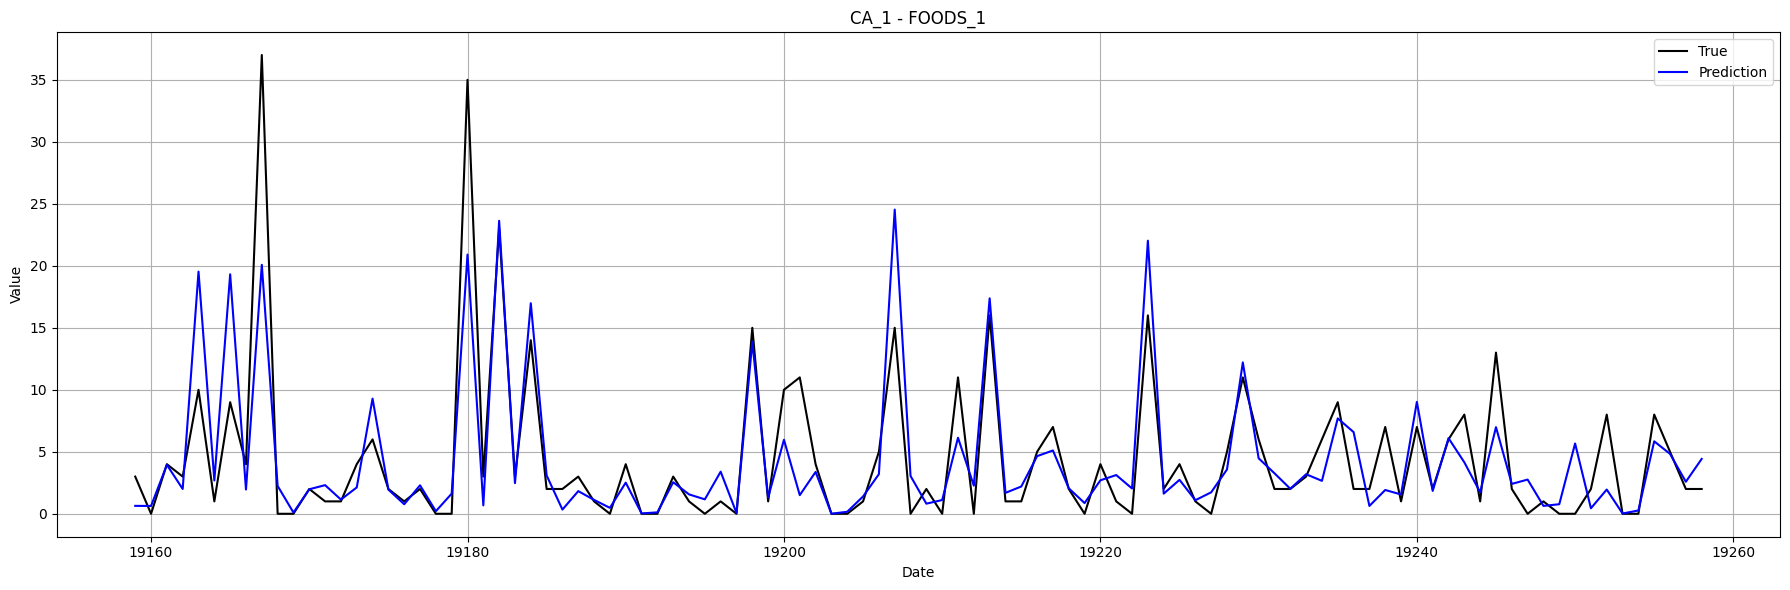

In [ ]:
plot_true_vs_pred(sample_group_df, true_col='true', pred_col='pred', n_points=100, title='CA_1 - FOODS_1')
